In [1]:
import matplotlib.pyplot as plt

In [2]:
import pickle

In [568]:
from tqdm import tqdm
import numpy as np
import numpy.linalg as nla
import scipy.linalg as la
from scipy.sparse import bsr_array
from copy import copy
from itertools import permutations
from functools import lru_cache


In [588]:
class GTN2:
    def __init__(self,Lx,Ly,history=True,seed=None,op=False,random_init=False,bcx=1,bcy=1,orbit=1,nshell=1):
        self.Lx= Lx # complex fermion sites
        self.Ly=Ly # complex fermion sites
        self.L = Lx* Ly*orbit # (Lx,Ly) in complex fermion sites
        self.orbit=orbit # number of orbitals
        self.history = history
        self.op = op
        self.random_init = random_init
        self.rng=np.random.default_rng(seed)
        self.C_m=self.correlation_matrix()
        self.Gamma_like=np.zeros_like(self.C_m)
        self.C_m_history=[self.C_m.copy()]
        self.n_history=[]
        self.i_history=[]
        self.p_history=[]
        self.seed = seed
        self.bcx = bcx # boundary condition in x direction, 0 for open, 1 for periodic, -1 for antiperiodic
        self.bcy = bcy # boundary condition in y direction, 0 for open, 1 for periodic, -1 for antiperiodic
        self.full_ix=set(range(self.C_m[-1].shape[0]))
        self.nshell = nshell

    def set(self,ij_list,n):
        """ij_list: [[i,j],...]
        n: [1,-1,...]
        simply set all Gamma[i,j]=n, Gamma[j,i]=-n
        """
        Gamma=self.C_m
        for ij,n in zip(ij_list,n):
            i,j=ij
            Gamma[i,j]=n
            Gamma[j,i]=-n

    def correlation_matrix(self):
        if self.op:
            pass
        else:
            Omega=np.array([[0,1.],[-1.,0]])
            Omega_diag=np.kron(np.eye(self.L),Omega)
            self.A_D=Omega_diag
            O=get_O(self.rng,2*self.L) if self.random_init else np.eye(2*self.L)
            Gamma=O@Omega_diag@O.T
        return (Gamma-Gamma.T)/2
    
    def measure_tri_op(self,i,j,p,Born=True,):
        '''measure the parity on i,j (Majorana sites) with probability p
        '''
        if Born:
            Gamma=self.C_m[i,j]
            n=get_Born_tri_op(p,Gamma,rng=self.rng)
            self.measure(n[0],[i,j])
        else:
            pass
    
    def measure(self,n,ix):
        ''' Majorana site index for ix, 
        n should be a scalar'''

        Psi=self.C_m
        proj=kraus(n)
        # ix_bar=np.array([i for i in np.arange(self.L*2) if i not in ix]) if not self.op else np.array([i for i in np.arange(self.L*4) if i not in ix])
        ix_bar=np.array([i for i in np.arange(self.C_m[-1].shape[0]) if i not in ix])
        # Psi=P_contraction(m,proj,ix,ix_bar)
        P_contraction_2(Psi,proj,ix,ix_bar,self.Gamma_like,reset_Gamma_like=False)

        # assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        if self.history:
            self.C_m_history.append(Psi.copy())
            self.n_history.append(n)
            self.i_history.append(ix)
            # self.MI_history.append(self.mutual_information_cross_ratio())
        else:
            self.C_m_history=[Psi]
            self.n_history=[n]
            self.i_history=[ix]
            # self.MI_history=[self.mutual_information_cross_ratio()]



    def measure_weak(self,A,ix,kind):
        """measure exp(-beta c^dag c), A = tanh(beta), sqrt(1-A^2) = 1/cosh(beta)"""
        Psi=self.C_m
        ix_bar=np.array(list(self.full_ix-set(ix)))
        if kind == 'onsite':
            proj=op_weak_onsite(A)
        elif kind == 'nn_x':
            proj=op_weak_nn_x(A)
        elif kind == 'nn_y':
            proj=op_weak_nn_y(A)
        P_contraction_2(Psi,proj,ix,ix_bar,self.Gamma_like,reset_Gamma_like=False)
        if self.history:
            self.C_m_history.append(Psi.copy())
            self.n_history.append([A])
            self.i_history.append(ix)
        else:
            self.n_history=[A]
            self.i_history=[ix]


    
    def measure_line_tri_op(self,p_list,pos,Born=True,even=True):
        """ apply along a specific line, e.g., (0,-1), mean all first index being 0 will be applied. (-1,1) means all second index being 1 will be measured
        even means it is "intra-unit cell" gamma
        odd means it is "inter-unit cell" gamma"""
        if pos[0]==-1 and pos[1]>-1:
            ix=[(i,pos[1]) for i in range(self.Lx)]
        elif pos[1]==-1 and pos[0]>-1:
            ix=[(pos[0],i) for i in range(self.Ly)]
        else:
            raise ValueError("pos should have only one `-1` to indicate the direction")
        if even:
            proj_range_1 = [self.linearize_idx(*idx,majorana=0) for idx in ix]
            proj_range_2 = [self.linearize_idx(*idx,majorana=1) for idx in ix]
        else:
            ix_ = ix[1:]+[ix[0]]
            if (pos[0]==-1 and pos[1]>-1 and self.bcy==0) or (pos[1]==-1 and pos[0]>-1 and self.bcx==0):
                ix = ix[:-1]
                ix_ = ix_[:-1]
            proj_range_1 = [self.linearize_idx(*idx,majorana=1) for idx in ix]
            proj_range_2 = [self.linearize_idx(*idx,majorana=0) for idx in ix_]
        # return proj_range_1,proj_range_2
        if isinstance(p_list,int) or isinstance(p_list,float):
            p_list=np.array([p_list]*len(proj_range_1))
        if self.history:
            self.p_history.append(p_list)
        else:
            self.p_history=[p_list]

        if Born:
            for i,j,p in zip(proj_range_1,proj_range_2,p_list):
                Gamma=self.C_m[i,j]
                n=get_Born_tri_op(p,Gamma,rng=self.rng)
                self.measure(n[0],[i,j])
        else:
            pass
    
    def measure_tri_sites(self,A,Amu,ij):
        """force measurement on a single "tri-site" (i,i+x,i+y)"""
        i,j = ij
        self.measure_weak(-Amu,ix=[self.linearize_idx(*ij,orbit_idx=0,majorana=idx) for idx in range(2)],kind='onsite')   # exp(-beta * c_iL^dag c_iL + h.c.)
        self.measure_weak(Amu,ix=[self.linearize_idx(*ij,orbit_idx=1,majorana=idx) for idx in range(2)],kind='onsite')   # exp(beta * c_iR^dag c_iR + h.c.)

        if self.bcx==1 or (i+1)<self.Lx:
            ij_x = [(i+1)%self.Lx,j]
            self.measure_weak(-A,ix=[self.linearize_idx(*ij,orbit_idx=0,majorana=idx) for idx in range(2)]+[self.linearize_idx(*ij_x,orbit_idx=0,majorana=idx) for idx in range(2)],kind='nn_x')    # exp(-beta * c_iL^dag c_i+x,L + h.c.)
            self.measure_weak(A,ix=[self.linearize_idx(*ij,orbit_idx=1,majorana=idx) for idx in range(2)]+[self.linearize_idx(*ij_x,orbit_idx=1,majorana=idx) for idx in range(2)],kind='nn_x')   # exp(beta * c_iR^dag c_i+x,R + h.c.)
            self.measure_weak(A,ix=[self.linearize_idx(*ij,orbit_idx=0,majorana=idx) for idx in range(2)]+[self.linearize_idx(*ij_x,orbit_idx=1,majorana=idx) for idx in range(2)],kind='nn_x')   # exp(beta * c_iL^dag c_i+x,R + h.c.)
            self.measure_weak(-A,ix=[self.linearize_idx(*ij,orbit_idx=1,majorana=idx) for idx in range(2)]+[self.linearize_idx(*ij_x,orbit_idx=0,majorana=idx) for idx in range(2)],kind='nn_x')   # exp(-beta * c_iR^dag c_i+x,L + h.c.)

        if self.bcy==1 or (j+1)<self.Ly:
            ij_y = [i,(j+1)%self.Ly]
            self.measure_weak(A,ix=[self.linearize_idx(*ij,orbit_idx=0,majorana=idx) for idx in range(2)]+[self.linearize_idx(*ij_y,orbit_idx=0,majorana=idx) for idx in range(2)],kind='nn_x')    # exp(beta * (-i*c_iL^dag c_i+y,L + h.c.)
            self.measure_weak(-A,ix=[self.linearize_idx(*ij,orbit_idx=1,majorana=idx) for idx in range(2)]+[self.linearize_idx(*ij_y,orbit_idx=1,majorana=idx) for idx in range(2)],kind='nn_x')    # exp(-beta * (-i*c_iL^dag c_i+y,L + h.c.)

            self.measure_weak(A,ix=[self.linearize_idx(*ij,orbit_idx=0,majorana=idx) for idx in range(2)]+[self.linearize_idx(*ij_y,orbit_idx=1,majorana=idx) for idx in range(2)],kind='nn_y')    # exp(beta * (-i*c_iL^dag c_i+y,L + h.c.)
            self.measure_weak(A,ix=[self.linearize_idx(*ij,orbit_idx=1,majorana=idx) for idx in range(2)]+[self.linearize_idx(*ij_y,orbit_idx=0,majorana=idx) for idx in range(2)],kind='nn_y')    # exp(beta * (-i*c_iL^dag c_i+y,L + h.c.)

    def op_Wannier(self,n,lower):
        """ project to "n" occupancy of "wf" mode"""
        if lower:
            wf = np.stack([(a,b) for a,b in zip(self.a_i.values(),self.b_i.values())]).flatten()
        else:
            wf = np.stack([(a,b) for a,b in zip(self.A_i.values(),self.B_i.values())]).flatten()

        # u=form_basis(wf)
        return Gamma_n1(tuple(wf),n)
    

    def measure_Wannier(self,ij,n,lower):
        """measure a single site, project to the Wannier state"""
        Psi=self.C_m

        i,j = ij
        if lower:
            ij_list = [((i+di)%self.Lx,(j+dj)%self.Ly) for di,dj in self.a_i.keys()]
        else:
            ij_list = [((i+di)%self.Lx,(j+dj)%self.Ly) for di,dj in self.A_i.keys()]
        ix= [self.linearize_idx(*ij,orbit_idx=orbit_idx,majorana=idx) for ij in ij_list for orbit_idx in range(2) for idx in range(2)]
        ix_bar=np.array(list(self.full_ix-set(ix)))
        proj = self.op_Wannier(n=n,lower=lower)
        P_contraction_2(Psi,proj,ix,ix_bar,self.Gamma_like,reset_Gamma_like=False)
        if self.history:
            self.C_m_history.append(Psi.copy())
            # self.n_history.append([r])
            self.i_history.append(ix)
        else:
            # self.n_history=[r]
            self.i_history=[ix]

        



    def linearize_idx(self,i,j,majorana=0,orbit_idx=0):
        return np.ravel_multi_index((i,j,orbit_idx,majorana),(self.Lx,self.Ly,self.orbit,2))
    def linearize_idx_span(self,ilist,jlist,n_orbits=2,shape_func=lambda i,j: True):
            multi_index=np.array([(i%self.Lx,j%self.Ly,orbit,maj) for i in ilist for j in jlist for orbit in range(n_orbits) for maj in range(2) if shape_func(i%self.Lx,j%self.Ly)])
            return np.ravel_multi_index(multi_index.T,(self.Lx,self.Ly,n_orbits,2))

    def delinearize_idx(self,idx,majorana=0):
        # return np.unravel_index(idx//2,(self.Lx,self.Ly)), idx%2
        return np.unravel_index(idx,(self.Lx,self.Ly,self.orbit,2))


    def von_Neumann_entropy_m(self,subregion,Gamma=None,fermion_idx=True):
        c_A=self.c_subregion_m(subregion,Gamma,fermion_idx=fermion_idx)
        val=nla.eigvalsh(1j*c_A)
        # self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2+1e-18j   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def entanglement_contour(self,subregion,fermion=False, Gamma=None, fermion_idx=True):
        # c_A=self.c_subregion_m(subregion)
        c_A=self.c_subregion_m(subregion,Gamma,fermion_idx=fermion_idx)+1e-18j
        C_f=(np.eye(c_A.shape[0])+1j*c_A)/2
        f,_=la.funm(C_f,lambda x: -x*np.log(x),disp=False)
        if fermion:
            return np.diag(f).real.reshape((-1,2)).sum(axis=1)
        else:
            return np.diag(f).real
    def c_subregion_m(self,subregion,Gamma=None,fermion_idx=True):
        if Gamma is None:
            Gamma=self.C_m
        if fermion_idx:
            subregion=self.linearize_index(subregion,2)
        
        return Gamma[np.ix_(subregion,subregion)]
    def linearize_index(self,subregion,n,k=2,proj=False):
        """convert fermion index to Majorana index, [needs to improve readability]"""
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        if proj:
            return np.int_(sorted(np.concatenate([n*subregion+i for i in range(0,n,k)])))
        else:
            return np.int_(sorted(np.concatenate([n*subregion+i for i in range(n)])))

def kraus(n):
    return np.array([[0,n[0],n[1],n[2]],
                    [-n[0],0,-n[2],n[1]],
                    [-n[1],n[2],0,-n[0]],
                    [-n[2],-n[1],n[0],0]])

def get_Born_tri_op(p,Gamma,rng=None,sigma=1):
    # num=Gamma.shape[0]
    rng=np.random.default_rng(rng)
    sign=rng.random(size=1)
    n1= (sign<p*(1+Gamma)/2)*(-1)+(sign>p*(1+Gamma)/2+1-p)
    n2,n3=get_inplane(n1, 1,rng=rng,sigma=sigma)
    return np.c_[n1,n2,n3]

def get_inplane(n1,num,rng=None,sigma=1):
    r=np.sqrt(1-n1**2)
    rng=np.random.default_rng(rng)
    phi=rng.random(num)*2*np.pi*sigma
    n2,n3=r*np.cos(phi),r*np.sin(phi)
    return n2,n3
def get_O(rng,n):
    rng=np.random.default_rng(rng)
    A=rng.normal(size=(n,n))
    AA=(A-A.T)/2
    return la.expm(AA)
def P_contraction_2(Gamma,Upsilon,ix,ix_bar,Gamma_like=None,reset_Gamma_like=True):
    """ same analytical expression for contraction as _contraction(), differences:
    1. assume intput and output tensor have the same shape, thus, it should be Gamma(L,R) -- Upsilon (L,R), where Gamma_R = Upsilon_L =Upsilon_R, such that in-place operator is applied here.
    2. manually compute the inverse of mat2 before
    Here, Gamma is m, and proj is Upsilon
    Assume Upsilon = [A,B;C,D], the logic is to first compute C= (1+ Gamma_RR @ Upsilon_LL)^{-1}, (where then B=-C.T) 
    then A= Upsilon_LL @C, D= Gamma_RR@ C.T
    ---
    reset_Gamma_like: in usual case, because each application of the gate will be like the brick layer, therefore, ix_bar will overwrite the previous. However, for the staircase pattern, one should reset it. 
    """
    Gamma_RR=Gamma[np.ix_(ix,ix)]
    Gamma_LR=Gamma[np.ix_(ix_bar,ix)]
    Upsilon_LL=Upsilon[:len(ix),:len(ix)]
    Upsilon_RR=Upsilon[len(ix):,len(ix):]
    Upsilon_RL=Upsilon[len(ix):,:len(ix)]
    eye=np.eye(len(ix))
    try: 
        C=nla.inv(Gamma_RR@Upsilon_LL+eye)
    except:
        raise ValueError("the contraction will lead to a vanishing state")
    A=Upsilon_LL@C
    D=Gamma_RR@C.T
    tmp=Gamma_LR@A@Gamma_LR.T
    if Gamma_like is None:
        Gamma_like=np.zeros_like(Gamma)
    if reset_Gamma_like:
        Gamma_like[:,:]=0
    Gamma_like[np.ix_(ix_bar,ix_bar)]=tmp
    Gamma+=Gamma_like
    Gamma[np.ix_(ix,ix_bar)]=Upsilon_RL@C@Gamma_LR.T
    Gamma[np.ix_(ix,ix)]=Upsilon_RR+Upsilon_RL@D@Upsilon_RL.T
    Gamma[np.ix_(ix_bar,ix)]=-Gamma[np.ix_(ix,ix_bar)].T
    # why is it neccessary?
    # Gamma-=Gamma.T
    # Gamma/=2

    if np.abs(np.einsum(Gamma,[0,1],Gamma,[1,0],[0])+1).max()>1e-10:
        Gamma[:,:]=purify(Gamma)
        Gamma-=Gamma.T
        Gamma/=2

def purify(A):
    # purify A, see App. B2 in PhysRevB.106.134206
    val,vec=np.linalg.eigh(A/1j)
    val[val<0]=-1
    val[val>0]=1
    return -(vec@np.diag(val)@vec.conj().T).imag
def purify_O(A,A_D):
    O,_,_=block_diagonalize(A)
    return O.T@A_D@O


def block_diagonalize(A,thres=1e-10):
    '''A is an anti symmetry matrix for covariance matrix
    block diagonalize is to find a real othorgonal matrix such that OAO^T=A_D, where A_D=\oplus a_k \omega, where \omega = [0,1;-1,0]

    See : arxiv:0902.1502 App B for more details
    '''
    assert np.abs(A.imag).max()<1e-10, f'A is not a real matrix {np.abs(A.imag).max()}'
    A=A.real
    assert np.abs(A+A.T).max()<1e-10, f'A is not antisymmetric'

    val,vec=np.linalg.eigh(A/1j)
    val_arg=val.argsort()
    val=val[val_arg[:A.shape[0]//2]]
    vec=vec[:,val_arg[:A.shape[0]//2]]
    perm_list=permutations(range(vec.shape[1]))
    for perm in perm_list:
        vec=vec[:,perm]
        diag_element=np.array([vec[2*x,x] for x in range(vec.shape[1])])
        if np.all(diag_element !=0):
            break

    # diag_element=np.array([vec[2*x,x] for x in range(vec.shape[1])])
    phase_factor=diag_element.conj()/np.abs(diag_element)
    # phase_factor[np.isinf(phase_factor)|np.isnan(phase_factor)]=1
    vec=phase_factor.reshape((1,-1))*vec
    vec_conj=vec.conj()
    U=np.zeros(A.shape,dtype=complex)
    U[:,1::2]=vec_conj
    U[:,::2]=vec
    G=lambda l:np.kron(np.eye(l),np.array([[1,1],[-1j,1j]])/np.sqrt(2))
    O=G(A.shape[0]//2)@U.T.conj()
    assert np.abs(O.imag).max()<1e-10, f'O is not a real matrix {np.abs(O.imag).max()}'
    O=O.real
    A_D=O@A@O.T
    return O,U,A_D

def op_weak_onsite(A):
    assert -1<=A<=1, "A should be within [0,1]"
    Gamma=np.zeros((4,4),dtype=float)
    Gamma[0,1]=Gamma[3,2]=A
    Gamma[0,2]=Gamma[1,3]=np.sqrt(1-A**2)
    return (Gamma-Gamma.T)

def op_weak_nn_x(A):
    """exp(beta* (c_i^dag c_j + c_j^dag c_i)), x stands for the Pauli x like nearest neighbor coupling"""
    assert -1<=A<=1, "A should be within [0,1]"
    Gamma=np.zeros((8,8),dtype=float)
    Gamma[0,3]=Gamma[5,6]=A
    Gamma[1,2]=Gamma[4,7]=-A
    Gamma[0,4]=Gamma[1,5]=Gamma[2,6]=Gamma[3,7]=np.sqrt(1-A**2)
    return (Gamma-Gamma.T)

def op_weak_nn_y(A):
    """exp(beta* (-1j*c_i^dag c_j + 1j*c_j^dag c_i)), y stands for the Pauli y like nearest neighbor coupling"""
    assert -1<=A<=1, "A should be within [0,1]"
    Gamma=np.zeros((8,8),dtype=float)
    Gamma[0,2]=Gamma[1,3]=A
    Gamma[4,6]=Gamma[5,7]=-A
    Gamma[0,4]=Gamma[1,5]=Gamma[2,6]=Gamma[3,7]=np.sqrt(1-A**2)
    return (Gamma-Gamma.T)

from opt_einsum import contract
def chern_number(Gamma,A_idx,B_idx,C_idx):
    P=(np.eye(Gamma.shape[0])-1j*Gamma)/2
    h=12*np.pi*1j*(contract("jk,kl,lj->jkl",P,P,P)-contract("jl,lk,kj->jkl",P,P,P))
    return h[np.ix_(A_idx,B_idx,C_idx)].sum()

def chern_number_quick(Gamma,A_idx,B_idx,C_idx):
    P=(np.eye(Gamma.shape[0])-1j*Gamma)/2
    P_AB=P[np.ix_(A_idx,B_idx)]
    P_BC=P[np.ix_(B_idx,C_idx)]
    P_CA=P[np.ix_(C_idx,A_idx)]
    P_AC=P[np.ix_(A_idx,C_idx)]
    P_CB=P[np.ix_(C_idx,B_idx)]
    P_BA=P[np.ix_(B_idx,A_idx)]
    h=12*np.pi*1j*(contract("jk,kl,lj->jkl",P_AB,P_BC,P_CA)-contract("jl,lk,kj->jkl",P_AC,P_CB,P_BA))
    assert np.abs(h.imag).max()<1e-10, "Imaginary part of h is too large"
    h=h.real
    # return h
    return h.sum()

def circle(i,j,center,radius, angle):
    i_c=i-center[0]
    j_c=j-center[1]
    return i_c**2/radius[0]**2+j_c**2/radius[1]**2<=1 and (angle[0]<=(np.angle(i_c+j_c*1j)%(2*np.pi))<angle[1])

# def form_basis(v1):
#     "With v1 being the first basis, find other basis to form a complete basis, return a matrix where each row is the coefficient of the basis"
#     v=np.zeros((v1.shape[0],v1.shape[0]),dtype=complex)
#     v[:,0]=v1
#     for i in range(1,v1.shape[0]):
#         all_zero=0*v1
#         all_zero[0],all_zero[i]=-v1[i],v1[0]
#         v[:,i]=all_zero
#     # return v
#     q,r = np.linalg.qr(v)
#     return q.T

# def Gamma_n1_diag(n):
#     """Generate the covariance matrix for eigenstate in L sites where the number density is n"""
#     L= len(n)
#     Gamma=np.zeros((4*L,4*L),dtype=float)
#     for idx,ni in enumerate(n):
#         Gamma[2*idx,2*idx+1]=(-1)**(ni+1)
#         Gamma[2*L+2*idx,2*L+2*idx+1]=(-1)**(ni)
#     return  Gamma - Gamma.T

# def Gamma_n1_diag(L,n):
#     """Generate the covariance matrix for eigenstate in L sites where the number density is n"""
#     # L= len(n)
#     Gamma=np.zeros((4*L,4*L),dtype=float)
#     Gamma[0,1]=-(1-2*n)
#     Gamma[2*L,2*L+1]=(1-2*n)
#     for idx in range(2,2*L):
#         Gamma[idx,idx+2*L]=1
#     return  Gamma - Gamma.T

# def unitary_to_otho(u):
#     """From a unitary matrix where each row represents a "eigenstate", to an othogonal matrix that can transform the digaonal Gamma in eigenstate to Gamma in original site basis"""
#     L=u.shape[0]
#     S= np.kron(np.eye(L), np.array([[1,1j],[1,-1j]]) )
#     S_inv= np.kron(np.eye(L),np.linalg.inv(np.array([[1,1j],[1,-1j]])) )
#     u_tilde = np.kron(u,np.array([[1,0,],[0,0]])) + np.kron(u.conj(),np.array([[0,0,],[0,1]]))
#     O = S_inv @ u_tilde @ S
#     O = np.kron(np.eye(2),O)    # Choi-isomorphism
#     assert np.max(np.abs(O.imag))<1e-10, 'O is not orthogonal'
#     return O.real

# def Gamma_n1_old(u,n):
#     """Generate the covariance matrix for eigenstate in L sites with occupancy n"""
#     Gamma = Gamma_n1_diag(len(u),n)
#     O = unitary_to_otho(u)
#     return  O.T @ Gamma @ O

@lru_cache(maxsize=None)
def Gamma_n1(u,n):
    L=len(u)
    u=u/np.linalg.norm(u)
    u_tilde=np.kron(u,np.array([[1,0,],[0,0]]))  + np.kron(u.conj(),np.array([[0,0,],[0,1]]))
    S0=np.array([[1,1j],[1,-1j]]) / np.sqrt(2)
    S= np.kron(np.eye(L), S0)
    epsilon = np.array([[0,2*n-1],[1-2*n,0]])
    Gamma11= S.T.conj() @ u_tilde.T.conj() @ S0 @ epsilon @ S0.T.conj() @ u_tilde @ S
    Gamma12= S.T.conj() @ (np.eye(2*L)-u_tilde.T.conj() @ u_tilde) @ S
    Gamma21 = -Gamma12.T
    Gamma22 = -Gamma11
    Gamma = np.block([[Gamma11,Gamma12],[Gamma21,Gamma22]])
    assert np.max(np.abs(Gamma.imag))<1e-10, 'Gamma is not real'
    return Gamma.real
    

def amplitude(nshell,nkx=500,nky=500,tau=[0,1],geometry = 'square', lower=True):
    """if gemoetry is square, then the shape is [i-nshell,i+nshell]x[j-nshell,j+nshell]"""
    
    kx = np.linspace(-np.pi,np.pi,nkx)
    ky = np.linspace(-np.pi,np.pi,nky)
    KX,KY = np.meshgrid(kx,ky)

    dx = np.sin(KX)
    dy = np.sin(KY)
    dz = 1-np.cos(KX)-np.cos(KY)
    E = np.sqrt(dx**2+dy**2+dz**2)
    cos_theta = dz/E
    sin_theta_exp_iphi = (dx+1j*dy)/E
    tau = np.array(tau)/np.linalg.norm(tau)
    if lower:
        ak = (1-cos_theta)/2*tau[0] - 1/2*sin_theta_exp_iphi.conj()*tau[1]
        bk = - 1/2*sin_theta_exp_iphi*tau[0] + (1+cos_theta)/2*tau[1]
    else:
        ak = (1+cos_theta)/2*tau[0] + 1/2*sin_theta_exp_iphi.conj()*tau[1]
        bk = 1/2*sin_theta_exp_iphi*tau[0] + (1-cos_theta)/2*tau[1]

    # ak=-1/2*(dx-1j*dy)/E
    # bk=1/2+dz/(2*E)

    def a_nint(i,j):
        a_int=ak * np.exp(1j * (KX * i + KY*j))
        return np.trapz(np.trapz(a_int,kx),ky)/(2*np.pi)**2
    def b_nint(i,j):
        b_int=bk * np.exp(1j * (KX * i + KY*j))
        return np.trapz(np.trapz(b_int,kx),ky)/(2*np.pi)**2

    if geometry == 'square':
        i_list = np.arange(-nshell,nshell+1)
        j_list = np.arange(-nshell,nshell+1)
        ij_list = [(i,j) for i in i_list for j in j_list]
    elif geometry == 'diamond':
        ij_list=[(i,j) for i in range(-nshell,nshell+1) for j in range(-nshell+abs(i),nshell+1 -abs(i))]
    a_i = {(i,j):a_nint(i,j) for i,j in ij_list}
    b_i = {(i,j):b_nint(i,j) for i,j in ij_list}
    return a_i,b_i

In [286]:
a_i_0,b_i_0=amplitude(1,tau=[0,1],)

In [287]:
a_i_0,b_i_0

({(-1, -1): (0.02902348183227568+0.029023481832275676j),
  (-1, 0): (2.168881922062419e-19+0.1664909147383517j),
  (-1, 1): (-0.02902348183227568+0.029023481832275676j),
  (0, -1): (0.16649091473835168+0j),
  (0, 0): (8.675527688249409e-19+0j),
  (0, 1): (-0.16649091473835168-2.8122277740499295e-18j),
  (1, -1): (0.029023481832275693-0.02902348183227568j),
  (1, 0): (4.736129911442252e-19-0.16649091473835168j),
  (1, 1): (-0.029023481832275693-0.02902348183227568j)},
 {(-1, -1): (-0.05837376856280478+0j),
  (-1, 0): (-0.11674753712560951-2.1246190256937667e-19j),
  (-1, 1): (-0.058373768562804754-5.624455548099859e-18j),
  (0, -1): (-0.11674753712560951+0j),
  (0, 0): (0.7455845790816228+0j),
  (0, 1): (-0.11674753712560951+0j),
  (1, -1): (-0.058373768562804754+5.624455548099859e-18j),
  (1, 0): (-0.11674753712560951+2.1246190256937667e-19j),
  (1, 1): (-0.05837376856280478+0j)})

In [288]:
a_i,b_i=amplitude(1,tau=[1,0],lower=False)

In [289]:
a_i,b_i

({(-1, -1): (-0.05837376856280478+0j),
  (-1, 0): (-0.11674753712560951-2.1246190256937667e-19j),
  (-1, 1): (-0.058373768562804754-5.624455548099859e-18j),
  (0, -1): (-0.11674753712560951+0j),
  (0, 0): (0.7455845790816228+0j),
  (0, 1): (-0.11674753712560951+0j),
  (1, -1): (-0.058373768562804754+5.624455548099859e-18j),
  (1, 0): (-0.11674753712560951+2.1246190256937667e-19j),
  (1, 1): (-0.05837376856280478+0j)},
 {(-1, -1): (0.029023481832275693-0.02902348183227568j),
  (-1, 0): (-4.736129911442252e-19-0.16649091473835168j),
  (-1, 1): (-0.029023481832275693-0.02902348183227568j),
  (0, -1): (0.16649091473835168-2.8122277740499295e-18j),
  (0, 0): (-8.675527688249409e-19+0j),
  (0, 1): (-0.16649091473835168+0j),
  (1, -1): (0.02902348183227568+0.029023481832275676j),
  (1, 0): (-2.168881922062419e-19+0.1664909147383517j),
  (1, 1): (-0.02902348183227568+0.029023481832275676j)})

In [319]:
v=np.hstack([a_i[0,0],b_i[0,0]])
np.abs(v)**2/(v.conj()@v)

array([0.25177955+0.j, 0.74822045+0.j])

In [320]:
a_i,b_i=amplitude(5,tau=[1.7,1])

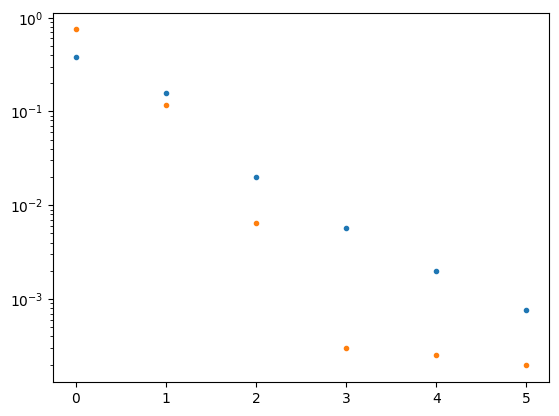

In [321]:
plt.plot([np.abs(b_i[(i,0)]) for i in range(0,5+1)],'.')
plt.plot([np.abs(b_i_0[(i,0)]) for i in range(0,5+1)],'.')
plt.yscale('log')

In [ ]:
np.stack([(a,b) for a,b in zip(gtn2.a_i.values(),gtn2.b_i.values())]).flatten()

In [508]:
# u=form_basis(np.array([0.7,-0.11,-0.11,-0.11,-0.11]))
u=form_basis(np.array([1,1,1j]))

In [469]:
O=unitary_to_otho(u)

In [509]:
Gamma1=Gamma_n1(u,n=1)

In [510]:
np.round(Gamma1[6:,:6],3)

array([[-0.667,  0.   ,  0.333,  0.   ,  0.   , -0.333],
       [ 0.   , -0.667,  0.   ,  0.333,  0.333,  0.   ],
       [ 0.333,  0.   , -0.667,  0.   ,  0.   , -0.333],
       [ 0.   ,  0.333,  0.   , -0.667,  0.333,  0.   ],
       [ 0.   ,  0.333,  0.   ,  0.333, -0.667,  0.   ],
       [-0.333,  0.   , -0.333,  0.   ,  0.   , -0.667]])

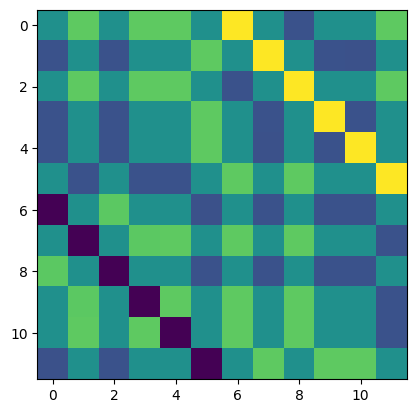

In [511]:
plt.imshow(Gamma1)

In [543]:
new_G=Gamma_n1(np.array([1,1,1j]),n=1)

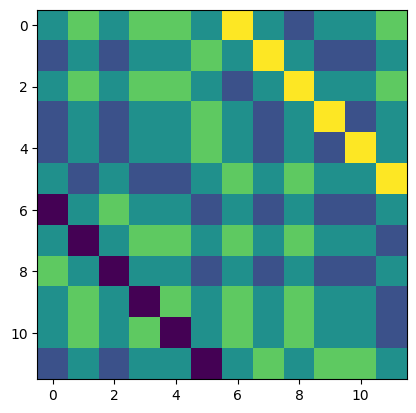

In [544]:
plt.imshow(new_G)

In [548]:
np.allclose(new_G,Gamma1)

True

In [563]:
vec=np.array([np.random.rand() for i in range(200)])
np.allclose(Gamma_n1_old(form_basis(vec),n=1),Gamma_n1(vec,n=1))

True

In [565]:
z=Gamma_n1_old(form_basis(vec),n=1)

In [567]:
zz=Gamma_n1(vec,n=1)

In [512]:
uu, vv = u[0],u[1:]

In [514]:
uu, vv = u[0],u[1:][::-1]

In [501]:
def RR(uu):
    if len(uu.shape)==1:
        uu=uu.reshape((1,-1))
    z= np.zeros((2*uu.shape[0],2*uu.shape[1]))
    z[::2,::2]=uu.real
    z[1::2,1::2]=uu.real
    z[::2,1::2]=-uu.imag
    z[1::2,::2]=uu.imag
    return z

In [502]:
uu

array([-0.57735027+0.j, -0.57735027-0.j, -0.57735027-0.j])

In [517]:
RR(uu).T.conj() @ np.array([[0,1],[-1,0]]) @ RR(uu) - Gamma1[:6,:6]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [529]:
S = np.array([[1,1j],[1,-1j]])

In [530]:
S.T.conj() @ uu.conj().T @ S @ np.array([[0,1],[-1,0]]) @ S.T.conj() @ uu @ S 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [527]:
(RR(np.eye(3)-(np.outer(uu.conj(),uu))) - Gamma1[:6,6:])

array([[ 1.11022302e-16, -0.00000000e+00, -1.11022302e-16,
        -0.00000000e+00,  0.00000000e+00, -5.55111512e-17],
       [ 0.00000000e+00,  1.11022302e-16,  0.00000000e+00,
        -1.11022302e-16,  5.55111512e-17,  0.00000000e+00],
       [-1.11022302e-16, -0.00000000e+00,  2.22044605e-16,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.11022302e-16,  0.00000000e+00,
         2.22044605e-16,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.55111512e-17,  0.00000000e+00,
         0.00000000e+00,  1.11022302e-16, -0.00000000e+00],
       [-5.55111512e-17,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.11022302e-16]])

In [533]:
1/2 *S.T.conj() @ np.array([[0,1],[-1,0]]) @ S

array([[0.+0.j, 0.-1.j],
       [0.-1.j, 0.+0.j]])

In [521]:
RR(vv).T.conj() @ RR(vv)  - Gamma1[:6,6:]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [515]:
RR(vv).T.conj() @ RR(vv)

array([[ 0.66666667,  0.        , -0.33333333,  0.        ,  0.        ,
         0.33333333],
       [ 0.        ,  0.66666667,  0.        , -0.33333333, -0.33333333,
         0.        ],
       [-0.33333333,  0.        ,  0.66666667,  0.        ,  0.        ,
         0.33333333],
       [ 0.        , -0.33333333,  0.        ,  0.66666667, -0.33333333,
         0.        ],
       [ 0.        , -0.33333333,  0.        , -0.33333333,  0.66666667,
         0.        ],
       [ 0.33333333,  0.        ,  0.33333333,  0.        ,  0.        ,
         0.66666667]])

In [589]:
gtn2=GTN2(Lx=12,Ly=12,history=True,random_init=False,bcx=1,bcy=1,seed=0,orbit=2,nshell=2)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='diamond',lower=True)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='diamond',lower=False)
sites_flip=np.sort(gtn2.rng.choice(np.arange(gtn2.L),size=gtn2.L//2,replace=False))
gtn2.set(ij_list = ([[2*site,2*site+1] for site in sites_flip]),n=[-1]*gtn2.L)

In [437]:
with open('C_m.pickle','rb') as f:
    C_m=pickle.load(f)
gtn2.C_m=C_m
gtn2.C_m_history[0]=C_m.copy()

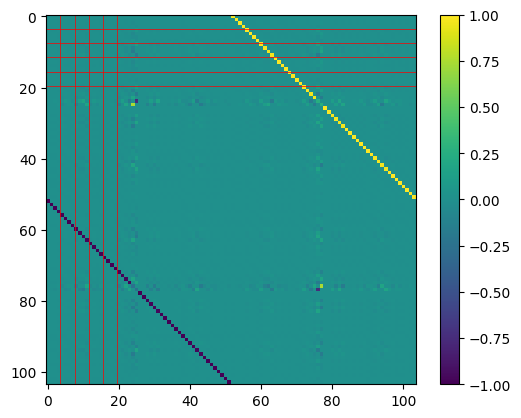

In [590]:
# op=gtn2.op_Wannier(n=1,lower=True)
op=gtn2.op_Wannier(n=0,lower=False)
plt.imshow(op)
for i in range(1,6):
    plt.axvline(i*4-0.5,color='r',lw=0.5)
    plt.axhline(i*4-0.5,color='r',lw=0.5)
plt.colorbar()

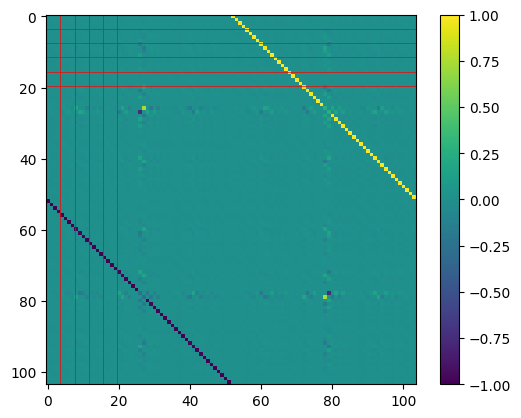

In [591]:
op=gtn2.op_Wannier(n=1,lower=True)
# op=gtn2.op_Wannier(n=0,lower=False)
plt.imshow(op)
for i in range(1,6):
    plt.axvline(i*4-0.5,color='r',lw=0.5)
    plt.axhline(i*4-0.5,color='r',lw=0.5)
plt.colorbar()

In [592]:
for _ in (range(4)):
    ij_list = [(i,j) for i in range(gtn2.Lx) for j in range(gtn2.Ly)]
    for i,j in tqdm(ij_list):
        gtn2.measure_Wannier(ij=[i,j],n=1,lower=True)
        gtn2.measure_Wannier(ij=[i,j],n=0,lower=False)

100%|██████████| 144/144 [00:30<00:00,  4.67it/s]


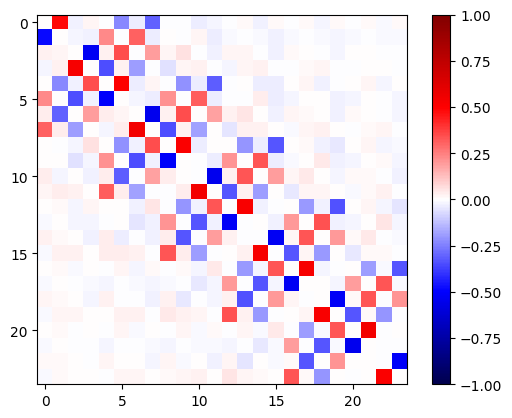

In [459]:
plt.imshow(gtn2.C_m[:24,:24],cmap='seismic',vmin=-1,vmax=1)
# plt.imshow(gtn2.C_m,cmap='seismic',vmin=-1,vmax=1)
# plt.imshow(gtn2.C_m_history[2])
# for i in range(1,gtn2.Ly):
#     plt.axvline(4*i*gtn2.Lx-0.5,color='r',lw=0.5)
#     plt.axhline(4*i*gtn2.Lx-0.5,color='r',lw=0.5)

# for i in range(1,6):
#     plt.axvline(i*4-0.5,color='r',lw=0.5)
#     plt.axhline(i*4-0.5,color='r',lw=0.5)
plt.colorbar()

In [270]:
wf = np.stack([(a,b) for a,b in zip(gtn2.a_i.values(),gtn2.b_i.values())]).flatten()
u=form_basis(wf)

In [ ]:
u.T.conj()@u

In [47]:
nu_list=[chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0)]
for _ in tqdm(range(2*gtn2.Lx)):
    ij_list = [(i,j) for i in range(gtn2.Lx) for j in range(gtn2.Ly)]
    for i,j in (ij_list):
        # gtn2.measure_tri_sites(A=0.5,Amu=0.5,ij=[i,j])
        gtn2.measure_tri_sites(A=0.5,Amu=0.99,ij=[i,j])
    nu_list.append(chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))

100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


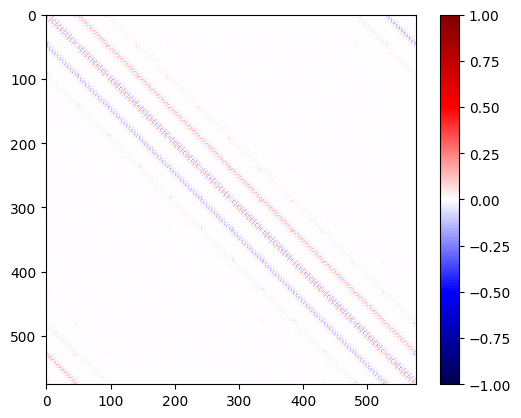

In [311]:
plt.imshow(gtn2.C_m_history[-1],vmin=-1,vmax=1,cmap='seismic')
plt.colorbar()

In [318]:
A_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx),np.arange(gtn2.Ly),shape_func=lambda i,j: circle(i,j,center=[gtn2.Lx/2,gtn2.Ly/2],radius=[gtn2.Lx/3,gtn2.Ly/3],angle=[0,np.pi/3*2]))
B_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx),np.arange(gtn2.Ly),shape_func=lambda i,j: circle(i,j,center=[gtn2.Lx/2,gtn2.Ly/2],radius=[gtn2.Lx/3,gtn2.Ly/3],angle=[np.pi/3*2,np.pi/3*4]))
C_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx),np.arange(gtn2.Ly),shape_func=lambda i,j: circle(i,j,center=[gtn2.Lx/2,gtn2.Ly/2],radius=[gtn2.Lx/3,gtn2.Ly/3],angle=[np.pi/3*4,np.pi/3*6]))

In [319]:
A_de_idx=np.array([gtn2.delinearize_idx(idx) for idx in A_idx_0])
B_de_idx=np.array([gtn2.delinearize_idx(idx) for idx in B_idx_0])
C_de_idx=np.array([gtn2.delinearize_idx(idx) for idx in C_idx_0])

(0.0, 12.0)

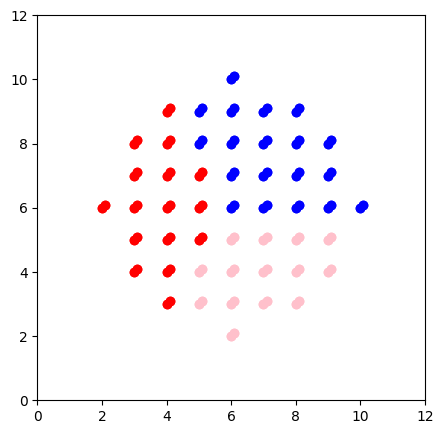

In [320]:
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(A_de_idx[:,0]+0.1*A_de_idx[:,2],A_de_idx[:,1]+0.1*A_de_idx[:,2],color='b')
ax.scatter(B_de_idx[:,0]+0.1*B_de_idx[:,2],B_de_idx[:,1]+0.1*B_de_idx[:,2],color='r')
ax.scatter(C_de_idx[:,0]+0.1*C_de_idx[:,2],C_de_idx[:,1]+0.1*C_de_idx[:,2],color='pink')
ax.set_xlim(0,gtn2.Lx)
ax.set_ylim(0,gtn2.Ly)

In [367]:
chern_number_quick(gtn2.C_m_history[-1],A_idx_0,B_idx_0,C_idx_0)
# chern_number_quick(C_m,A_idx_0,B_idx_0,C_idx_0)

-1.9877139660570968

Text(0, 0.5, '$\\nu$')

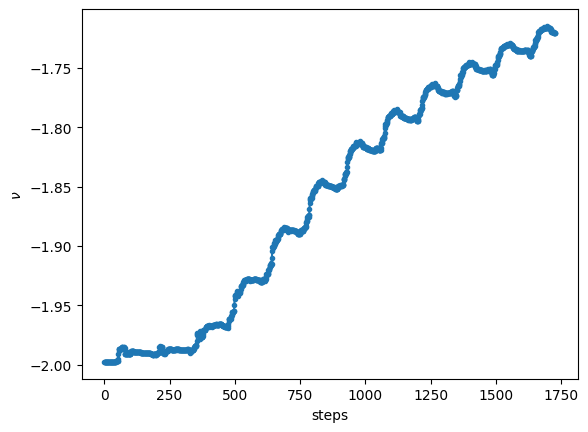

In [393]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

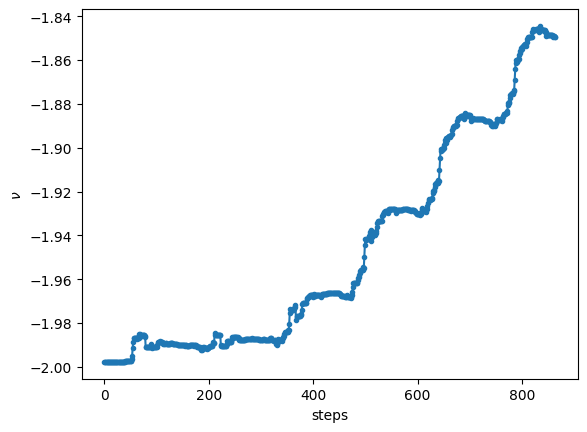

In [415]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

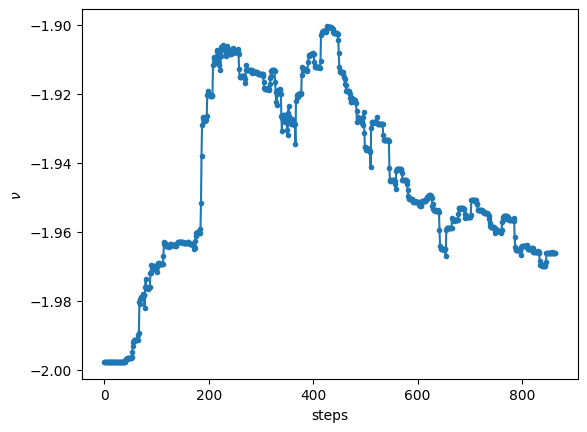

In [420]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

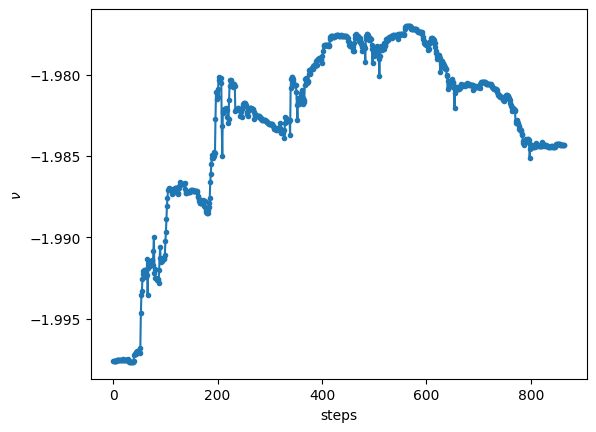

In [425]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

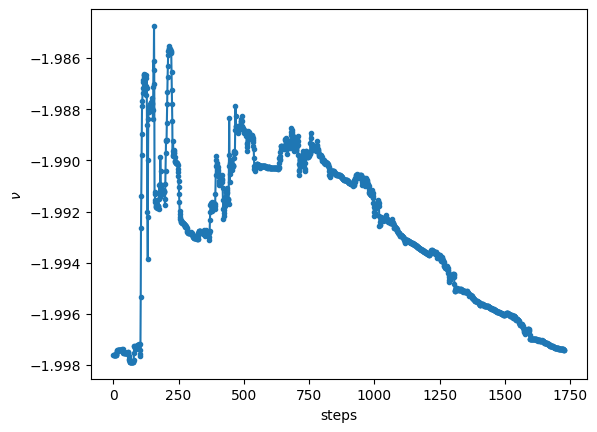

In [442]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

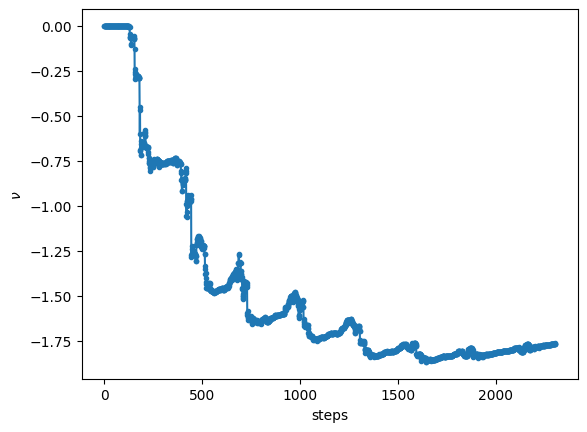

In [451]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

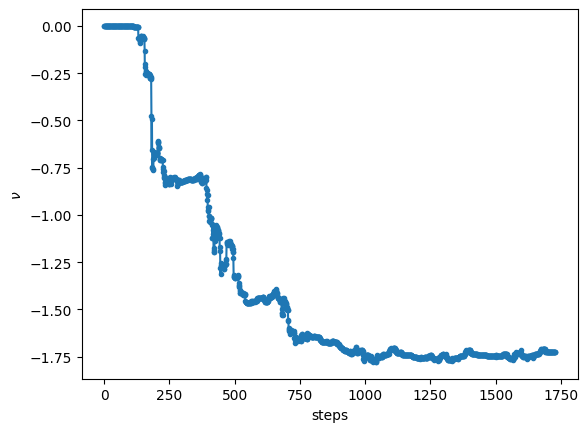

In [458]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

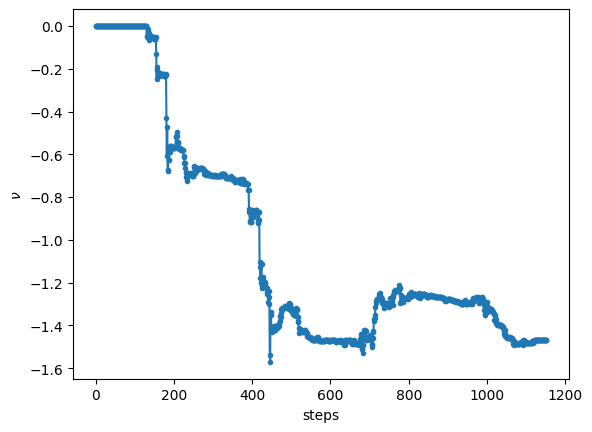

In [593]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

In [204]:
r0 = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

In [273]:
r_ = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

In [208]:
r1 = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

In [216]:
r2 = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

In [223]:
r3 = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

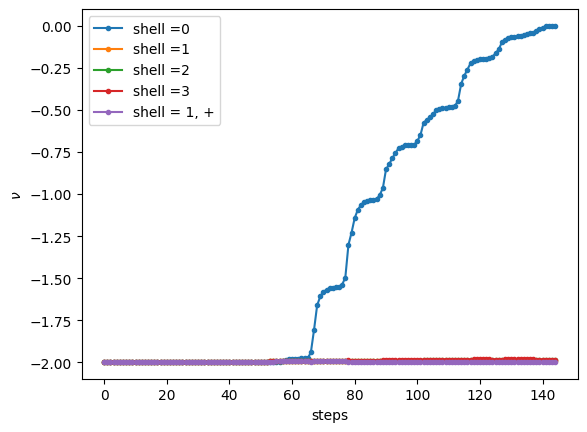

In [274]:
for idx,r in enumerate([r0,r1,r2,r3]):
    plt.plot(r,'.-',label=f'shell ={idx}')
plt.plot(r_,'.-',label='shell = 1, +')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')
plt.legend()

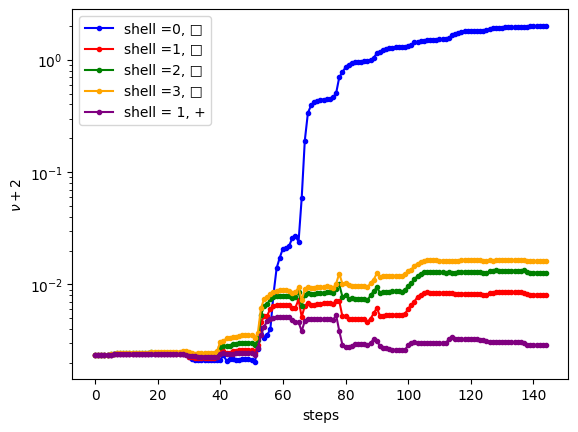

In [282]:
color_list = iter(['b','r','g','orange','purple'])
for idx,r in enumerate([r0,r1,r2,r3]):
    plt.plot(np.array(r)+2,'.-',label=f'shell ={idx}, □',color=next(color_list))
plt.plot(np.array(r_)+2,'.-',label='shell = 1, +',color=next(color_list))
plt.xlabel('steps')
plt.ylabel(r'$\nu+2$')
plt.yscale('log')
plt.legend()

Text(0, 0.5, '$\\nu$')

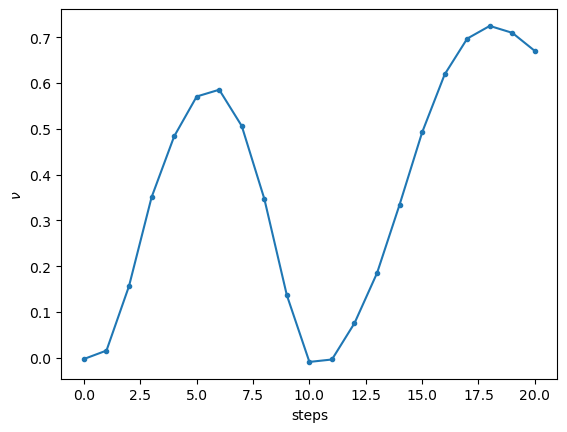

In [51]:
plt.plot(nu_list,'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

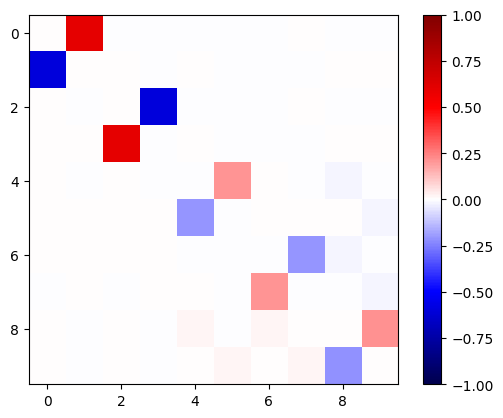

In [104]:
plt.imshow(gtn2.C_m[:10,:10],vmin=-1,vmax=1,cmap='seismic')
plt.colorbar()

In [98]:
C_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx//2,gtn2.Lx),np.arange(gtn2.Ly))

In [102]:
gtn2.von_Neumann_entropy_m(C_idx_0,fermion_idx=False)

14.779519209094035

In [83]:
ec=gtn2.entanglement_contour(C_idx_0,fermion_idx=False)

In [76]:
C_de_idx=np.array([gtn2.delinearize_idx(idx) for idx in C_idx_0])


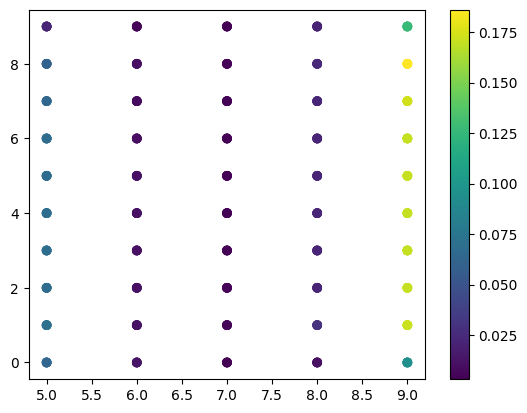

In [58]:
plt.scatter(C_de_idx[:,0],C_de_idx[:,1],c=ec)
plt.colorbar()

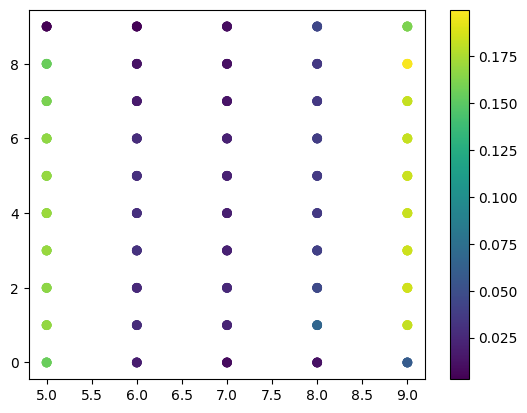

In [103]:
plt.scatter(C_de_idx[:,0],C_de_idx[:,1],c=ec)
plt.colorbar()

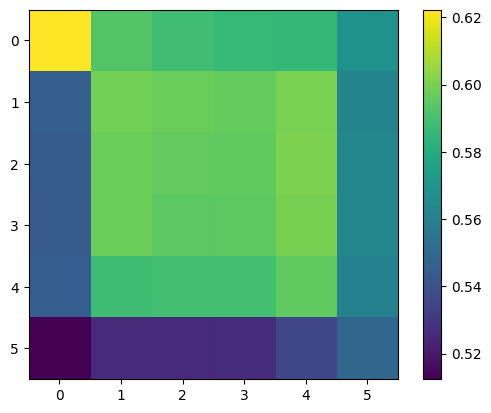

In [503]:
plt.imshow((1/2-np.diag(gtn2.C_m,k=1)[::2]/2).reshape((gtn2.Lx,gtn2.Ly,2))[:,:,1])
plt.colorbar()

In [12]:
A_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx//4,gtn2.Lx//2),np.arange(gtn2.Ly//4,gtn2.Ly//2))
B_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx//4,gtn2.Lx//2),np.arange(gtn2.Ly//2,gtn2.Ly//4*3))
C_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx//2,gtn2.Lx//4*3),np.arange(gtn2.Ly//4,gtn2.Ly//4*3))

In [14]:
chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0)

-1.6731606887940065

In [474]:
A_idx=gtn2.linearize_idx_span(range(gtn2.Lx//2),range(gtn2.Ly//2))

In [475]:
B_idx=gtn2.linearize_idx_span(range(gtn2.Lx//2,gtn2.Lx),range(gtn2.Ly//2))

In [476]:
C_idx=gtn2.linearize_idx_span(range(gtn2.Lx),range(gtn2.Ly//2,gtn2.Ly))

In [ ]:
gtn2.linearize_idx_span([0,1],[0,1])

array([ 0,  1,  2,  3,  4,  5,  6,  7, 20, 21, 22, 23, 24, 25, 26, 27])

In [481]:
P=(np.eye(gtn2.C_m.shape[0])-1j*gtn2.C_m)/2

In [452]:
from opt_einsum import contract

In [482]:
h=12*np.pi*1j*(contract("jk,kl,lj->jkl",P,P,P)-contract("jl,lk,kj->jkl",P,P,P))

In [486]:
h[np.ix_(A_idx,B_idx,C_idx)].sum()

(-5.873079800267078e-14+0j)

In [488]:
chern_number(gtn2.C_m,A_idx,B_idx,C_idx)

(-5.873079800267078e-14+0j)

In [458]:
gtn2.linearize_idx(i=0,j=1,orbit_idx=0,majorana=0)  

4

In [462]:
np.ravel_multi_index([[0,1],[0,1]],[5,5])

array([0, 6])

In [441]:
np.max(np.abs(P.T.conj()-P))

1.249000902703301e-16

In [443]:
np.max(np.abs(P@P-P))

2.886579864025407e-14

In [450]:
np.max(np.abs(P.T.conj()@P-P))

2.886579872166139e-14

In [421]:
p=gtn2.C_m

array([[ 1.02290150e-17,  2.12627086e-01,  9.59583208e-03, ...,
        -2.39034291e-02,  4.23823023e-03, -3.98507131e-02],
       [-2.12627086e-01, -6.90892406e-18, -1.03912934e-01, ...,
         1.31669302e-02, -1.32222135e-02,  3.51792143e-03],
       [-9.59583208e-03,  1.03912934e-01,  4.33579278e-18, ...,
         3.15582823e-02, -1.39048758e-02,  3.85001289e-02],
       ...,
       [ 2.39034291e-02, -1.31669302e-02, -3.15582823e-02, ...,
        -6.73966481e-18, -8.45147817e-04, -1.38972953e-03],
       [-4.23823023e-03,  1.32222135e-02,  1.39048758e-02, ...,
         8.45147817e-04, -4.75642556e-19, -6.59453835e-01],
       [ 3.98507131e-02, -3.51792143e-03, -3.85001289e-02, ...,
         1.38972953e-03,  6.59453835e-01,  4.76738986e-19]])

In [ ]:
even start from stead state?
random start to project to avoid even-odd effect?
Kitaev's topological invariant


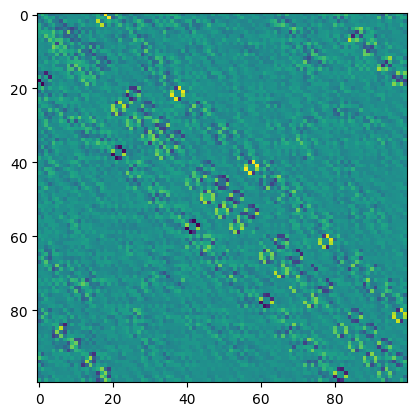

In [156]:
plt.imshow(gtn2.C_m)

In [21]:
gtn2.measure_weak(0.9,[0,1],'onsite')
gtn2.measure_weak(-0.9,[2,3],'onsite')

In [240]:
for t in range(gtn2.Ly*gtn2.Lx):
    for ly in range(gtn2.Ly):
        gtn2.measure_line_tri_op(p_list=0.5,pos=(ly,-1),even=True)
        gtn2.measure_line_tri_op(p_list=1-0.5,pos=(ly,-1),even=False)

In [ ]:
gtn2.C_m

In [196]:
gtn2.C_m[:4,:4]

array([[ 0.        ,  0.9850454 ,  0.17229498,  0.        ],
       [-0.9850454 ,  0.        ,  0.        ,  0.        ],
       [-0.17229498,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [190]:
gtn2.von_Neumann_entropy_m(np.arange(gtn2.L//2))

2.1442952223724603e-15

In [107]:
gtn2.measure_line_tri_op(p_list=0.5,pos=(-1,1),even=False)

([3, 11, 19], [10, 18, 26])

In [39]:
gtn2.linearize_idx(1,0,0)

8

In [42]:
gtn2.delinearize_idx(10)

((1, 1), 0)

In [6]:
gtn2.measure_tri_op(0,1,p=1)

In [40]:
gtn2.history

True

In [48]:
gtn2.n_history

[array([0.        , 0.98804366, 0.15417434])]

# ED of local Ham

In [6]:
import numpy as np

In [7]:
numpy.__version__

'1.24.0'

In [8]:
from quspin.basis import spin_basis_general

In [38]:
L = 6
sites = np.arange(L)

In [39]:
basis = spin_basis_general(
    L,
)

In [ ]:
print(basis)

In [1]:
from quspin.basis import spinless_fermion_basis_1d

In [2]:
from quspin.operators import hamiltonian, exp_op

In [45]:
L = 10  # system size
J = 1.0  # uniform hopping
deltaJ = 0.1  # bond dimerisation
Delta = 0.5  # staggered potential
# beta = 100.0  # inverse temperature for Fermi-Dirac distribution
##### construct single-particle Hamiltonian #####
# define site-coupling lists
hop_pm = [[-J - deltaJ * (-1) ** i, i, (i + 1) % L] for i in range(L)]  # PBC
hop_mp = [[+J + deltaJ * (-1) ** i, i, (i + 1) % L] for i in range(L)]  # PBC
stagg_pot = [[Delta * (-1) ** i, i] for i in range(L)]
# define static and dynamic lists
static = [["+-", hop_pm], ["-+", hop_mp], ["n", stagg_pot]]
dynamic = []
# define basis
basis = spinless_fermion_basis_1d(L, Nf=1)
# build real-space Hamiltonian
H = hamiltonian(static, dynamic, basis=basis, dtype=np.float64)
# diagonalise real-space Hamiltonian
E, V = H.eigh()

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [68]:
import numpy as np

In [79]:
L=6
basis = spinless_fermion_basis_1d(L, Nf=4)


In [80]:
basis.Ns

15

In [18]:
mu=1
t=1
Delta=1

In [19]:
onsite = [[-mu,i] for i in range(0,6,2)] + [[mu,i] for i in range(1,6,2)]
LL = [[-t,0,2],[-t,0,4],[-t,2,0],[-t,4,0]]
RR = [[t,1,3],[t,1,5],[t,3,1],[t,5,1]]
LR = [[Delta,0,3],[-Delta,1,2],[-1j*Delta,0,5],[-1j*Delta,1,4],[Delta,3,0],[-Delta,2,1],[1j*Delta,5,0],[1j*Delta,4,1]]
# xR
# xLR
# xRL

static=[["n", onsite],["+-",LL],["+-",RR],["+-",LR]]
dynamic=[]

In [61]:
basis=spinless_fermion_basis_1d(L, Nf=1)

In [62]:
H=hamiltonian(static, dynamic, basis=basis, )

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [63]:
H.todense()

matrix([[-1.+0.j,  0.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  0.-1.j],
        [ 0.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  0.-1.j,  1.+0.j],
        [-1.+0.j, -1.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 1.+0.j,  1.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
        [-1.+0.j,  0.+1.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+1.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [64]:
E, V = H.eigh()

In [65]:
E

array([-2.97839968, -1.4404177 , -0.23309265,  0.23309265,  1.4404177 ,
        2.97839968])

In [58]:
E

array([-2.97839968, -1.4404177 , -0.23309265,  0.23309265,  1.4404177 ,
        2.97839968])

In [66]:
V[:,0]

array([ 0.65407316-0.j        ,  0.20083574+0.20083574j,
        0.43212143+0.10151424j, -0.21488764-0.05048154j,
        0.43212143-0.10151424j, -0.05048154-0.21488764j])

In [70]:
np.abs(V[:,0])**2

array([0.4278117 , 0.08066999, 0.19703407, 0.04872508, 0.19703407,
       0.04872508])

In [71]:
np.abs(V[:,1])**2

array([0.08528068, 0.14368696, 0.37335642, 0.01215976, 0.37335642,
       0.01215976])

In [72]:
np.abs(V[:,2])**2

array([0.23896356, 0.02358711, 0.26588029, 0.10284437, 0.26588029,
       0.10284437])

In [73]:
np.abs(V[:,3])**2

array([0.02358711, 0.23896356, 0.10284437, 0.26588029, 0.10284437,
       0.26588029])

In [60]:
basis.states

array([62, 61, 59, 55, 47, 31], dtype=uint32)

In [44]:
basis.int_to_state(62)

'|1 1 1 1 1 0>'

In [ ]:
basis.

In [75]:
[basis.int_to_state(basis.states[1]) ]

'|1 0 1 0 0 0>'

In [50]:
import matplotlib.pyplot as plt

In [55]:
(H.as_dense_format())

(10, 10)

In [12]:
states = (
    basis.states
)

In [17]:
array_inds = np.arange(
    basis.Ns
)

In [18]:
array_inds

array([0, 1, 2, 3])

In [19]:
print("\n'array index' and 'states' columns when printing the basis:")
print("array indices:", array_inds)
print("states in int rep:", states)


'array index' and 'states' columns when printing the basis:
array indices: [0 1 2 3]
states in int rep: [3 2 1 0]


In [20]:
s = basis.states[2]
array_ind_s = basis.index(
    s
) 

In [22]:
print(
    "\nprint array index of s, and s (in int rep); Note: the array index is crucial for reading-off matrix elements"
)
print(array_ind_s, s)



print array index of s, and s (in int rep); Note: the array index is crucial for reading-off matrix elements
2 1


In [34]:
fock_state_str_s = "|00>"  # works also if the ket-forming strings | > are omitted
int_rep_s = basis.state_to_int(fock_state_str_s)
print("\nprint Fock state string of s, and s (in int rep):")
print(fock_state_str_s, int_rep_s)


print Fock state string of s, and s (in int rep):
|00> 0


In [35]:
fock_s = basis.int_to_state(int_rep_s, bracket_notation=True)
print("\nprint Fock state string of s, and s (in int rep):")
print(fock_s, int_rep_s)


print Fock state string of s, and s (in int rep):
|0 0> 0


In [36]:
fock_s = basis.int_to_state(int_rep_s, bracket_notation=False)
print("print Fock state string (without | and >) of s, and s (in int rep):")
print(fock_s, int_rep_s)

print Fock state string (without | and >) of s, and s (in int rep):
00 0


In [37]:
array_ind_s = 2
int_rep_s = basis.states[array_ind_s]
fock_s = basis.int_to_state(int_rep_s, bracket_notation=True)
print("\nprint array index, int rep, and fock state rep of s:")
print(array_ind_s, int_rep_s, fock_s)  # compare with print(basis) output
# 


print array index, int rep, and fock state rep of s:
2 1 |0 1>
